In [2]:

import os
import inspect
import sys
sys.path.insert(0, "../")


from experiment_information import *
from data import *
from helpers import *
from _version import __version__
import seaborn as sns
import matplotlib.pyplot as plt



import pandas as pd
import numpy as np
import logging
import pprint
import re
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 1
# mpl.rcParams['legend.fontsize'] = 13

# mpl.rcParams['axes.titlesize'] = 15
# mpl.rcParams['axes.labelsize'] = 13
# mpl.rcParams['xtick.labelsize'] = 10
# mpl.rcParams['ytick.labelsize'] = 10


In [3]:
# Define the potting



In [4]:
import numpy as np

In [5]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
# with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
with DatabaseHandler(logger,"../experiments/experiments.db") as dbHandler:

    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_state_evolution["calibrations"] = df_state_evolution["calibrations"].apply(lambda x: json.loads(x))
    df_erm = dbHandler.get_erms()
    df_erm["analytical_calibrations"] = df_erm["analytical_calibrations"].apply(lambda x: json.loads(x))
    df_erm["erm_calibrations"] = df_erm["erm_calibrations"].apply(lambda x: json.loads(x))
    # delete incomplete experiments (bad, deletes running experiments...)
    # dbHandler.delete_incomplete_experiments()

# def explode_calibrations(df):
#     a = df["calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["calibrations"])
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["calibrations","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"calibrations":"calibration","ps":"p_calibration"})
#     return df
# df_state_evolution = explode_calibrations(df_state_evolution)
# def explode_erm_calibrations(df):
#     a = df["erm_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["erm_calibrations"])
#     b = df["analytical_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["analytical_calibrations"])
#     # drop the dp and ps columns from b
#     b = b.drop(columns=["dp","ps"])
#     # rename the columns of b
#     b = b.rename(columns={"calibrations":"analytical_calibration"})
#     # rename the columns of a
#     a = a.rename(columns={"calibrations":"erm_calibration"})
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     df = pd.concat([df,b],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["erm_calibration","analytical_calibration","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"ps":"p_calibration"})
#     return df
# df_erm = explode_erm_calibrations(df_erm)

def explode_measures(df, new_columns, columns):
    for column in columns:
        def transform(column):
            # replace NaN in the column string by 0
            column = column.replace("NaN","0")
            # replace null in the column string by 0
            column = column.replace("null","0")
            # replace Infinity in the column string by np.inf
            column = column.replace("Infinity","np.inf")
            return eval(column)
        df[column] = df[column].apply(transform)

    exploded = df.explode(columns).reset_index(drop=True)

    for new_column, column in zip(new_columns, columns):
        if len(exploded[column].tolist()) > 0:
            exploded[["attack_epsilon",new_column]] = pd.DataFrame(exploded[column].tolist(), index=exploded.index)
        else:
            exploded[new_column] = np.nan
            # set attack_epsilon
            exploded["attack_epsilon"] = np.nan

    exploded = exploded.drop(columns=columns)
    return exploded


def explode_erm_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","adversarial_generalization_errors_overlap","fair_adversarial_errors","test_losses","boundary_loss_test_es"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","adversarial_generalization_error_overlap","fair_adversarial_error","test_loss","boundary_loss_test"]
    return explode_measures(df, new_columns, columns)

def explode_state_evolution_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","fair_adversarial_errors","first_term_fair_errors","second_term_fair_errors","third_term_fair_errors","test_losses","data_model_adversarial_generalization_errors","gamma_robustness_es","boundary_loss_test_es"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","fair_adversarial_error","first_term_fair_error","second_term_fair_error","third_term_fair_error","test_loss","data_model_adversarial_generalization_error","gamma_robustness","boundary_loss_test"] #
    # columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","fair_adversarial_errors","second_term_fair_errors","test_losses","data_model_adversarial_generalization_errors"]
    # new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","fair_adversarial_error","second_term_fair_error","test_loss","data_model_adversarial_generalization_error"] #
    return explode_measures(df, new_columns, columns)
    

df_erm = explode_erm_measures(df_erm)

df_state_evolution = explode_state_evolution_measures(df_state_evolution)
    

print("Current code version, ", __version__)

Current code version,  101


In [6]:
def extract_first_eigenvalue(row, column):
    array = row[column]

    # load json string to array
    array = json.loads(array)
    return np.array([float(array[0])])
def extract_second_eigenvalue(row, column):
    array = row[column]

    # load json string to array
    array = json.loads(array)
    return np.array([float(array[-1])])
def extract_trace(row, column):
    array = row[column]

    # load json string to array
    array = json.loads(array)
    return np.array([float(sum(array))])

df2 = df_state_evolution.reset_index()


df2["sigmax_first_ev"] = df2.apply(lambda row: extract_first_eigenvalue(row, "sigmax_eigenvalues"), axis=1)
df2["sigmax_second_ev"] = df2.apply(lambda row: extract_second_eigenvalue(row, "sigmax_eigenvalues"), axis=1)
df2["sigmax_trace"] = df2.apply(lambda row: extract_trace(row, "sigmax_eigenvalues"), axis=1)

df2["sigmatheta_first_ev"] = df2.apply(lambda row: extract_first_eigenvalue(row, "sigmatheta_eigenvalues"), axis=1)
df2["sigmatheta_second_ev"] = df2.apply(lambda row: extract_second_eigenvalue(row, "sigmatheta_eigenvalues"), axis=1)
df2["sigmatheta_trace"] = df2.apply(lambda row: extract_trace(row, "sigmatheta_eigenvalues"), axis=1)

df2["xtheta_first_ev"] = df2.apply(lambda row: extract_first_eigenvalue(row, "xtheta_eigenvalues"), axis=1)
df2["xtheta_second_ev"] = df2.apply(lambda row: extract_second_eigenvalue(row, "xtheta_eigenvalues"), axis=1)
df2["xtheta_trace"] = df2.apply(lambda row: extract_trace(row, "xtheta_eigenvalues"), axis=1)

# columns = ["sigmax_first_ev","sigmax_second_ev","sigmax_trace","sigmatheta_first_ev","sigmatheta_second_ev","sigmatheta_trace","xtheta_first_ev","xtheta_second_ev","xtheta_trace"]

# for column in columns:
#     # apply mean and std to the new column
#     df_result = df2[column].apply(lambda x: pd.Series({"mean":x, "std":0}))
#     multiindex = pd.MultiIndex.from_product([[column], ['mean', 'std']], names=['', ''])
#     df_result.columns = multiindex
#     # Concatenate the original DataFrame with the computed values DataFrame
#     df2 = pd.concat([df2, df_result], axis=1)

# drop the original eigenvalues columns
df2 = df2.drop(columns=["sigmax_eigenvalues","sigmatheta_eigenvalues","xtheta_eigenvalues"])

df_state_evolution = df2


In [7]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
version_choice = "100"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(5)

,experiment_id,experiment_name,duration,problem_types,code_version,date,state_evolution_repetitions,erm_repetitions,alphas,epsilons,...,taus,ps,dp,d,experiment_type,completed,data_model_types,data_model_names,data_model_descriptions,gamma_fair_error
72,e2e06001-5fb9-45a9-b24c-13ced10b08ce,OptimalDefense,220.073220,"[""Logistic""]",100,2024-01-31 06:02:30,1,20,[20],"[0.001, 0.0011, 0.0013, 0.0015, 0.0017, 0.002,...",...,[0.0],null,0.01,1000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel""]","[""KFeaturesModel_TeacherDefense_TeacherAttacke...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
71,04a8c1fc-9044-4473-bbbf-bb67048f670a,OptimalDefense,58.451196,"[""Logistic""]",100,2024-01-31 05:57:00,1,5,[20],"[0.001, 0.0011, 0.0013, 0.0015, 0.0017, 0.002,...",...,[0.0],null,0.01,1000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel""]","[""KFeaturesModel_TeacherDefense_TeacherAttacke...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
70,5a037c7b-4d09-472a-9a06-2670e5c0cd17,OptimalDefense,2.717105,"[""Logistic""]",100,2024-01-31 05:54:11,1,0,[20],"[0.005, 0.0054, 0.0059, 0.0064, 0.0069, 0.0075...",...,[0.0],null,0.01,1000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel""]","[""KFeaturesModel_TeacherDefense_TeacherAttacke...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
69,18332129-c690-420f-bce0-3ab90173a831,OptimalDefense,10.286233,"[""Logistic""]",100,2024-01-31 05:52:28,1,0,[20],"[0.001, 0.0011, 0.0013, 0.0015, 0.0017, 0.002,...",...,[0.0],null,0.01,1000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel""]","[""KFeaturesModel_TeacherDefense_TeacherAttacke...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
68,1542a374-93fe-4268-a094-ce0fb9f5bf99,OptimalDefense,10.270680,"[""Logistic""]",100,2024-01-31 05:45:39,1,0,[20],"[0.001, 0.0011, 0.0013, 0.0015, 0.0017, 0.002,...",...,[0.0],null,0.01,1000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel""]","[""KFeaturesModel_TeacherDefense_TeacherAttacke...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001


In [8]:
df_state_evolution["estimation_error"] = 1 + df_state_evolution["q"] - 2 * df_state_evolution["m"]

In [9]:
experiment_loc = 0

# extract and print the top experiment_id
experiment_id = df_experiments.iloc[experiment_loc]["experiment_id"]
print(experiment_id)

# extract and print the experiment type
experiment_type = df_experiments.iloc[experiment_loc]["experiment_type"]
print(experiment_type)

# extract and print the data model type and data_model name used
data_model_types = df_experiments.iloc[experiment_loc]["data_model_types"]
# convert it to the enum
data_model_types = [DataModelType[data_model_type] for data_model_type in json.loads(data_model_types)]
data_model_names = [name for name in json.loads(df_experiments.iloc[experiment_loc]["data_model_names"])]
data_model_descriptions = df_experiments.iloc[experiment_loc]["data_model_descriptions"]
for data_model_type in data_model_types:
    print(data_model_type.name)
print(data_model_names)
print(data_model_descriptions)

# print the experiment name
experiment_name = df_experiments.iloc[experiment_loc]["experiment_name"]
print(experiment_name)

# print the experiment problem types
experiment_problem_types = df_experiments.iloc[experiment_loc]["problem_types"]
experiment_problem_types = json.loads(experiment_problem_types)
print(experiment_problem_types)

e2e06001-5fb9-45a9-b24c-13ced10b08ce
Sweep
KFeaturesModel
KFeaturesModel
['KFeaturesModel_TeacherDefense_TeacherAttacked___OptimalDefense', 'KFeaturesModel_OrthogonalDefense_OrthogonalAttacked___OptimalDefense']
["2 Features, Theta Identity, Sigma_upsilon Identity, Sigma_delta Identity", "2 Features, Theta Identity, Sigma_upsilon Identity, Sigma_delta Identity"]
OptimalDefense
['Logistic']


In [10]:
data_model_name_dict = {}
data_model_name_dict["VanillaGaussian"] = "Vanilla Gaussian"
data_model_name_dict["2_VanillaGaussian"] = "Vanilla Gaussian"
data_model_name_dict["VanillaGaussianThetaFirst"] = "Vanilla Gaussian - Teacher 10:1"
data_model_name_dict["VanillaGaussianTimes10"] = "Vanilla Gaussian x10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]"] = "Strong Weak 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1 1]"] = "Strong Weak 5:1"
data_model_name_dict["2_KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1 1]"] = "Strong Weak 5:1"
data_model_name_dict["2_KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]"] = "Strong Weak 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[10  1]"] = "Strong Weak 5:1 - Teacher 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[10  1]"] = "Strong Weak 10:1 - Teacher 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[ 1 10]"] = "Strong Weak 5:1 - Teacher 1:10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[ 1 10]"] = "Strong Weak 10:1 - Teacher 1:10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[1 1]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Non-Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[5 5]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[5 5]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Non-Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[1 1]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[1 1]_SD_1_1_SU_1_1"] = "Non-Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[5 5]_SD_1_1_SU_1_1"] = "Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[5 5]_SD_1_1_SU_1_1"] = "Non-Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[1 1]_SD_1_1_SU_1_1"] = "Robust Non-Useful"

data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[2 2]_[2 2]_SD_1_1_SU_1_1"] = "Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[4 4]_SD_1_1_SU_1_1"] = "Non-Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[2 2]_[0.5 0.5]_SD_1_1_SU_1_1"] = "Robust Non-Useful"


data_model_name_dict['KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[0.5 0.5]_[2 2]_SD_1_1_SU_1_1'] = "Non-Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[0.5 0.5]_[8 8]_SD_1_1_SU_1_1"] = "Non-Robust Useful"


data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[2.  0.5]_[1 1]_SD_1_1_SU_1_1"] = "Invariant Defence"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingFirstStronger_AttackingIdentity_[0.5 0.5]_[2.  0.5]_[1 1]_SD_2_1_SU_1_1"] = "Protecting Robust"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[2.  0.5]_[1 1]_SD_1_2_SU_1_1"] = "Protecting Non-Robust"


data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[1 1]_SD_1_1_SU_1_1"] = "Invariant Defence"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingFirstStronger_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[1 1]_SD_2_1_SU_1_1"] = "Protecting Robust"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[1 1]_SD_1_2_SU_1_1"] = "Protecting Non-Robust"

In [11]:
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
gd = df_erm[df_erm["experiment_id" ] == experiment_id]
# make the column subspace_overlaps to string
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: str(x))

# create a json colum
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: json.loads(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: json.loads(x))
from pandas import json_normalize
# normalize the json column
normalized = json_normalize(state_evolution["subspace_overlaps"])
normalized_gd = json_normalize(gd["subspace_overlaps"])



def explode_array_column(row, col):
    return pd.Series(row[col])

# reset the index of the original dataframe
state_evolution = state_evolution.reset_index(drop=True)
gd = gd.reset_index(drop=True)

for col in normalized.columns:
    expanded_cols = normalized.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)
    state_evolution = pd.concat([state_evolution, expanded_cols], axis=1)

for col in normalized_gd.columns:
    expanded_cols = normalized_gd.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)

    gd = pd.concat([gd, expanded_cols], axis=1)



/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_15480/3541688095.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_15480/3541688095.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: str(x))
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_15480/3541688095.py:8: 

In [12]:
state_evolution["subspace_overlaps_ratio"] = state_evolution["subspace_overlaps_ratio"].apply(lambda x: str(x))
state_evolution["subspace_overlaps_ratio"] = state_evolution["subspace_overlaps_ratio"].apply(lambda x: json.loads(x))
normalized = json_normalize(state_evolution["subspace_overlaps_ratio"])
# rename the columns of the normalized dataframe
for column in normalized.columns:
    normalized = normalized.rename(columns={column:column+"_ratio"})
# merge the normalized dataframe with the original dataframe
state_evolution = pd.concat([state_evolution, normalized], axis=1)
# drop the original subspace_overlaps column
state_evolution = state_evolution.drop(columns=["subspace_overlaps_ratio"])

gd["subspace_overlaps_ratio"] = gd["subspace_overlaps_ratio"].apply(lambda x: str(x))
gd["subspace_overlaps_ratio"] = gd["subspace_overlaps_ratio"].apply(lambda x: json.loads(x))
normalized = json_normalize(gd["subspace_overlaps_ratio"])
# rename the columns of the normalized dataframe
for column in normalized.columns:
    normalized = normalized.rename(columns={column:column+"_ratio"})
# merge the normalized dataframe with the original dataframe
gd = pd.concat([gd, normalized], axis=1)
# drop the original subspace_overlaps column
gd = gd.drop(columns=["subspace_overlaps_ratio"])


In [13]:
# def compute_mu_usefulness(row):
#     rho = row["rho"]
#     tau = row["tau"]

#     rho = float(rho)
#     tau = float(tau)

#     return np.sqrt(2 / np.pi) * rho / np.sqrt( rho + tau**2 )

# def compute_gamma_robustness(row):
#     rho = row["rho"]
#     tau = row["tau"]


#     rho = float(rho)
#     tau = float(tau)

#     return np.sqrt(2 / np.pi) * tau / np.sqrt( rho + tau**2 )

# def compute_mu_usefulness_ratio(row):

In [14]:
# create a column for the difference between the adversarial_generalization_error and the generalization_error for both the state evolution and the erm
state_evolution["difference_adv_gen"] = state_evolution["adversarial_generalization_error"] - state_evolution["generalization_error"]
gd["difference_adv_gen"] = gd["adversarial_generalization_error"] - gd["generalization_error_erm"]


state_evolution["ratio_adv_gen"] = state_evolution["adversarial_generalization_error"] / state_evolution["generalization_error"]
gd["ratio_adv_gen"] = gd["adversarial_generalization_error"] / gd["generalization_error_erm"]

In [15]:
# create a column for the noise contribution
def noise_contribution(rho: float, tau: float) -> float:
    if tau == 0:
        tau = 1e-10
    return 0.5 - np.arctan( np.sqrt( rho / tau**2 ) ) / np.pi

state_evolution["noise_contribution"] = state_evolution.apply(lambda x: noise_contribution(x["rho"], x["tau"]), axis=1)
gd["noise_contribution"] = gd.apply(lambda x: noise_contribution(x["rho"], x["tau"]), axis=1)

In [16]:
# create a column for the noiseless generalization error without the noise contribution
state_evolution["noiseless_generalization_error"] = state_evolution["generalization_error"] - state_evolution["noise_contribution"]
gd["noiseless_generalization_error_erm"] = gd["generalization_error_erm"] - gd["noise_contribution"]

# create a column for the adversarial noiseless generalization error without the noise contribution
state_evolution["noiseless_adversarial_generalization_error"] = state_evolution["adversarial_generalization_error"] - state_evolution["noise_contribution"]
gd["noiseless_adversarial_generalization_error"] = gd["adversarial_generalization_error"] - gd["noise_contribution"]

In [17]:
def noiseless_angle_to_generalisation(angle):
    return np.arccos(angle) / np.pi

state_evolution["noiseless_angle_to_generalisation"] = state_evolution.apply(lambda x: noiseless_angle_to_generalisation(x["angle"]), axis=1)
gd["noiseless_angle_to_generalisation"] = gd.apply(lambda x: noiseless_angle_to_generalisation(x["angle"]), axis=1)

In [18]:
# create a column for the A/sqrt(q*N) for both the state evolution and the erm
state_evolution["A_over_sqrt_qN"] = state_evolution["A"] / np.sqrt(state_evolution["q"] * state_evolution["N"])
gd["A_over_sqrt_qN"] = gd["A"] / np.sqrt(gd["q"] * gd["N"])

In [19]:
# create a column for m/sqrt( rho*q - m**2 ) vs A/sqrt(q*N) for both the state evolution and the erm
state_evolution["m_over_sqrt_rhoq_minus_m2"] = state_evolution["m"] / np.sqrt(state_evolution["rho"] * state_evolution["q"] - state_evolution["m"]**2)
gd["m_over_sqrt_rhoq_minus_m2"] = gd["m"] / np.sqrt(gd["rho"] * gd["q"] - gd["m"]**2)

In [20]:
# strip the data_model_name if there is a sequence ___text at the end
def strip_data_model_name(data_model_name):
    return re.sub(r"___.*","",data_model_name)
state_evolution["data_model_name"] = state_evolution["data_model_name"].apply(strip_data_model_name)
gd["data_model_name"] = gd["data_model_name"].apply(strip_data_model_name)

In [21]:
gd = gd.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","data_model_name"]) #,"p_calibration"
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","data_model_name"]) #,"p_calibration"

# drop id, code_version, experiment_id, date, initial_condition, test_against_epsilons, calibrations, abs_tol, min_iter,max_iter,blend_fpe,int_lims,subspace_overlaps
state_evolution = state_evolution.drop(columns=["id","code_version","experiment_id","date","initial_condition","test_against_epsilons","calibrations","abs_tol","min_iter","max_iter","blend_fpe","int_lims","subspace_overlaps","data_model_type","data_model_description"])
# drop id, code_version, experiment_id, test_against_epsilons, date, subspace_overlaps, analytical_calibrations, erm_calibrations, 
gd = gd.drop(columns=["id","code_version","experiment_id","test_against_epsilons","date","subspace_overlaps","analytical_calibrations","erm_calibrations","data_model_type","data_model_description"])

state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
gd.columns = [col+"_erm" for col in gd.columns]

state_evolution = state_evolution.groupby(level=[0,1,2,3,4,5,6]).agg(["mean","std"]) #,4
gd = gd.groupby(level=[0,1,2,3,4,5,6]).agg(["mean","std"]) #,4
df = state_evolution.join(gd, how="outer")
df.sort_index()
df

index_state_evolution  \
                                                                                                                        mean   
alpha epsilon tau lam   problem_type attack_epsilon data_model_name                                                            
20.0  0.0010  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5143.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5114.0   
      0.0011  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5144.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5113.0   
      0.0013  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5145.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5115.0   
      0.0015  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5146.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5116.0   
      0.0017  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5147.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5117.0   
      0.0020  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5148.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5118.0   
      0.0022  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5149.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5119.0   
      0.0026  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5150.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5120.0   
      0.0029  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5151.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5121.0   
      0.0034  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5152.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5122.0   
      0.0039  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5153.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5123.0   
      0.0044  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5154.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5124.0   
      0.0051  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5155.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5125.0   
      0.0058  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5156.0   
                                                    KFeaturesModel_TeacherDefense_TeacherAttacked                     5126.0   
      0.0066  0.0 0.001 Logistic     0.006          KFeaturesModel_OrthogonalDefense_OrthogonalAtta...                5157.0   
       

In [22]:
# extract unique data_model_name from index
data_model_names = df.index.get_level_values("data_model_name").unique()
data_model_names

Index(['KFeaturesModel_OrthogonalDefense_OrthogonalAttacked', 'KFeaturesModel_TeacherDefense_TeacherAttacked'], dtype='object', name='data_model_name')

In [23]:
# store the dataframe as a pickle file
if not os.path.exists("Pickles"):
    os.makedirs("Pickles")
if not os.path.exists("Pickles/powerlaw.pkl"):
    df.to_pickle("Pickles/powerlaw.pkl")

In [24]:
# load the dataframe from the pickle file
df = pd.read_pickle("Pickles/powerlaw.pkl")

In [25]:
df

index_state_evolution  \
                                                                                                                   mean   
alpha      epsilon tau  lam   problem_type attack_epsilon data_model_name                                                 
0.1585     0.0     0.05 0.001 Logistic     0.2            KFeaturesModel_PowerLaw_Coefficient_0.5                2115.0   
                                                          KFeaturesModel_PowerLaw_Coefficient_1.5                2055.0   
                                                          KFeaturesModel_PowerLaw_Coefficient_2.5                2002.0   
                                                          KFeaturesModel_PowerLaw_Coefficient_3.5                1972.0   
           0.2     0.05 0.001 Logistic     0.2            KFeaturesModel_PowerLaw_Coefficient_0.5                2116.0   
...                                                                                                                 ...   
10000.0000 0.0     0.05 0.001 Logistic     0.2            KFeaturesModel_PowerLaw_Coefficient_3.5                2088.0   
           0.2     0.05 0.001 Logistic     0.2            KFeaturesModel_PowerLaw_Coefficient_0.5                2180.0   
                                                          KFeaturesModel_PowerLaw_Coefficient_1.5                2141.0   
                                                          KFeaturesModel_PowerLaw_Coefficient_2.5                2129.0   
                                                          KFeaturesModel_PowerLaw_Coefficient_3.5                2078.0   

                                                                                                       \
                                                                                                  std   
alpha      epsilon tau  lam   problem_type attack_epsilon data_model_name                               
0.1585     0.0     0.05 0.001 Logistic     0.2            KFeaturesModel_PowerLaw_Coefficient_0.5 NaN   
                                                          KFeaturesModel_PowerLaw_Coefficient_1.5 NaN   
                                                          KFeaturesModel_PowerLaw_Coefficient_2.5 NaN   
                                                          KFeaturesModel_PowerLaw_Coefficient_3.5 NaN   
           0.2     0.05 0.001 Logistic     0.2            KFeaturesModel_PowerLaw_Coefficient_0.5 NaN   
...                                                                                                ..   
10000.0000 0.0     0.05 0.001 Logistic     0.2            KFeaturesModel_PowerLaw_Coefficient_3.5 NaN   
           0.2     0.05 0.001 Logistic     0.2            KFeaturesModel_PowerLaw_Coefficient_0.5 NaN   
                                                          KFeaturesModel_PowerLaw_Coefficient_1.5 NaN   
                                                          KFeaturesModel_PowerLaw_Coefficient_2.5 NaN   
                                                          KFeaturesModel_PowerLaw_Coefficient_3.5 NaN   

                                                                                                  duration_state_evolution  \
                                                                                                                      mean   
alpha      epsilon tau  lam   problem_type attack_epsilon data_model_name                                                    
0.1585     0.0     0.05 0.001 Logistic     0.2            KFeaturesModel_PowerLaw_Coefficient_0.5                 0.060791   
                                                          KFeaturesModel_PowerLaw_Coefficient_1.5                 0.143259   
                                                          KFeaturesModel_PowerLaw_Coefficient_2.5                 0.768748   
                                                          KFeaturesModel_PowerLaw_Coefficient_3.5                 3.032063   
           0.2     0.0

# Extracting Data

In [26]:
# extract unique epsilons
epsilons = df.index.get_level_values("epsilon").unique()
epsilons

Index([0.0, 0.2], dtype='float64', name='epsilon')

In [27]:
# keep only attack_epsilon = 0.2
df = df.xs(0.2, level="attack_epsilon")

In [28]:
data_model_names = df.index.get_level_values("data_model_name").unique()
data_model_names

Index(['KFeaturesModel_PowerLaw_Coefficient_0.5',
       'KFeaturesModel_PowerLaw_Coefficient_1.5',
       'KFeaturesModel_PowerLaw_Coefficient_2.5',
       'KFeaturesModel_PowerLaw_Coefficient_3.5'],
      dtype='object', name='data_model_name')

In [29]:
# create a dictionary of dataframes for each data_model_name
df_dict = {}
for data_model_name in data_model_names:

    # the data_model_name is given by a string of this form 'KFeaturesModel_PowerLaw_Coefficient_3.5'
    # we want to extract the coefficient
    # split the string by '_'
    split = data_model_name.split("_")
    # extract the coefficient
    beta = split[-1]
    # convert the beta to a float
    beta = float(beta)

    


    df_data_model = df.xs(data_model_name, level="data_model_name")

    # for each data_model_name, create a dictionary
    eps_dict = {}

    for epsilon in epsilons:


        eps_df = df_data_model.xs(epsilon, level="epsilon")

        alphas = eps_df.index.get_level_values("alpha").unique()
        adversarial_error_0 = eps_df["adversarial_generalization_error_state_evolution"]["mean"].values
        generalization_error_0 = eps_df["generalization_error_state_evolution"]["mean"].values
        boundary_error_0 = eps_df["difference_adv_gen_state_evolution"]["mean"].values
        class_preserving = eps_df["fair_adversarial_error_state_evolution"]["mean"].values

        adversarial_error_erm = eps_df["adversarial_generalization_error_erm"]["mean"].values
        generalization_error_erm = eps_df["generalization_error_erm_erm"]["mean"].values
        boundary_error_erm = eps_df["difference_adv_gen_erm"]["mean"].values
        class_preserving_erm = eps_df["fair_adversarial_error_erm"]["mean"].values

        adversarial_error_erm_std = eps_df["adversarial_generalization_error_erm"]["std"].values
        generalization_error_erm_std = eps_df["generalization_error_erm_erm"]["std"].values
        boundary_error_erm_std = eps_df["difference_adv_gen_erm"]["std"].values
        class_preserving_erm_std = eps_df["fair_adversarial_error_erm"]["std"].values

        alphas = np.array(alphas)
        adversarial_error_0 = np.array(adversarial_error_0)
        generalization_error_0 = np.array(generalization_error_0)
        boundary_error_0 = np.array(boundary_error_0)
        class_preserving = np.array(class_preserving)

        adversarial_error_erm = np.array(adversarial_error_erm)
        generalization_error_erm = np.array(generalization_error_erm)
        boundary_error_erm = np.array(boundary_error_erm)
        class_preserving_erm = np.array(class_preserving_erm)

        adversarial_error_erm_std = np.array(adversarial_error_erm_std)
        generalization_error_erm_std = np.array(generalization_error_erm_std)
        boundary_error_erm_std = np.array(boundary_error_erm_std)
        class_preserving_erm_std = np.array(class_preserving_erm_std)

        eps_0_dict = {}
        eps_0_dict["alphas"] = alphas
        eps_0_dict["adversarial_error"] = adversarial_error_0
        eps_0_dict["generalization_error"] = generalization_error_0
        eps_0_dict["boundary_error"] = boundary_error_0
        eps_0_dict["class_preserving"] = class_preserving

        eps_0_dict["adversarial_error_erm"] = adversarial_error_erm
        eps_0_dict["generalization_error_erm"] = generalization_error_erm
        eps_0_dict["boundary_error_erm"] = boundary_error_erm
        eps_0_dict["class_preserving_erm"] = class_preserving_erm

        eps_0_dict["adversarial_error_erm_std"] = adversarial_error_erm_std
        eps_0_dict["generalization_error_erm_std"] = generalization_error_erm_std
        eps_0_dict["boundary_error_erm_std"] = boundary_error_erm_std
        eps_0_dict["class_preserving_erm_std"] = class_preserving_erm_std


        eps_dict[epsilon] = eps_0_dict


    df_dict[beta] = eps_dict


# Plotting

/Users/kasimirtanner/opt/anaconda3/envs/pdm/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


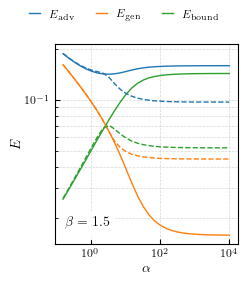

In [30]:

IMG_DIRECTORY = "./Assets/powerlaw"
if not os.path.exists(IMG_DIRECTORY):
    os.makedirs(IMG_DIRECTORY)


def save_plot(fig, name, formats=["pdf","jpg"], date=False):
    current_date = datetime.datetime.now().strftime("%Y-%m-%d")
    for f in formats:        
        path = "{}".format(name) + "_{}".format(current_date) + "." + f
        if not date:
            path = "{}".format(name) + "." + f
        fig.savefig(            
            os.path.join(IMG_DIRECTORY, path),
            format=f,
        )


def set_size(width, fraction=1, subplots=(1, 1)):
    if width == "thesis":
        width_pt = 426.79135
    elif width == "beamer":
        width_pt = 307.28987
    else:
        width_pt = width

    fig_width_pt = width_pt * fraction
    inches_per_pt = 1 / 72.27

    golden_ratio = (5**0.5 - 1) / 2

    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * (golden_ratio) * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


# width = 1.5 * 458.63788

multiplier = 1.25 
width = multiplier * 487.8225
multiplier = 1.25
width = multiplier * 1.5 * 234.8775

plt.style.use("../latex_ready.mplstyle")

tuple_size = set_size(width, fraction=0.50)
tuple_size = (2.375,2.7)

multiplier = 0.9
second_multiplier = 0.7


# import Line2D for custom legend
from matplotlib.lines import Line2D

fig, axes = plt.subplots(
    nrows=1,
    ncols=1,
    sharex=True,
    sharey=True,
    figsize=( tuple_size[0], tuple_size[1]),
    gridspec_kw={"hspace": 0,"wspace": 0},
)


# ICML adjustments
fig.subplots_adjust(left=0.2)
# fig.subplots_adjust(bottom=0.16)
fig.subplots_adjust(top=0.85)
fig.subplots_adjust(right=0.97)
# plt.subplots_adjust(bottom=0.30)



# Create a custom legend
custom_legend = []

linestyles = ["solid", "dashed", "dashdot", "dotted"]


for epsilon_idx, epsilon in enumerate(epsilons):

    # ax = axes[epsilon_idx]
    ax = axes

    for df_idx, (key, value) in enumerate(df_dict.items()):

        beta = key


        eps_dict = value[epsilon]

        if beta == 0.5 or beta > 1.5:
            continue

        alphas = eps_dict["alphas"]
        adversarial_error = eps_dict["adversarial_error"]
        generalization_error = eps_dict["generalization_error"]
        boundary_error = eps_dict["boundary_error"]
        class_preserving = eps_dict["class_preserving"]

        adversarial_error_erm = eps_dict["adversarial_error_erm"]
        generalization_error_erm = eps_dict["generalization_error_erm"]
        boundary_error_erm = eps_dict["boundary_error_erm"]
        class_preserving_erm = eps_dict["class_preserving_erm"]

        adversarial_error_erm_std = eps_dict["adversarial_error_erm_std"]
        generalization_error_erm_std = eps_dict["generalization_error_erm_std"]
        boundary_error_erm_std = eps_dict["boundary_error_erm_std"]
        class_preserving_erm_std = eps_dict["class_preserving_erm_std"]


        adversarial_lines = ax.plot(alphas, adversarial_error, linestyle=linestyles[epsilon_idx],color="C0")
        ax.plot(alphas, generalization_error, linestyle=linestyles[epsilon_idx],color="C1")
        ax.plot(alphas, boundary_error,linestyle=linestyles[epsilon_idx], color="C2")
        # ax.plot(alphas, class_preserving,linestyle=linestyles[df_idx], color="C3")

        custom_legend.append(Line2D([0],[0],color="C0", linestyle=linestyles[df_idx]))
        custom_legend.append(Line2D([0],[0],color="C1", linestyle=linestyles[df_idx]))
        custom_legend.append(Line2D([0],[0],color="C2", linestyle=linestyles[df_idx]))
        # custom_legend.append(Line2D([0],[0],color="C3", linestyle=linestyles[df_idx]))

        ax.errorbar(
            alphas,
            adversarial_error_erm,
            yerr=adversarial_error_erm_std,
            fmt=".",
            markersize=1,
            color="C0"
        )
        ax.errorbar(
            alphas,
            generalization_error_erm,
            yerr=generalization_error_erm_std,
            fmt=".",
            markersize=1,
            color="C1"
        )
        ax.errorbar(
            alphas,
            boundary_error_erm,
            yerr=boundary_error_erm_std,
            fmt=".",
            markersize=1,
            color="C2"
        )
        # axs.errorbar(
        #     alphas,
        #     class_preserving_erm,
        #     yerr=class_preserving_erm_std,
        #     fmt=".",
        #     markersize=1,
        #     color="C3"
        # )

    ax.legend(title=f"$\\beta={1.5}$")
    # Set the major ticks to face inwards
    ax.tick_params(axis='both', which='major', direction='in')

    # Set the minor ticks to face inwards
    ax.tick_params(axis='both', which='minor', direction='in')


axes.set_xscale("log")
axes.set_yscale("log")


axes.set_ylabel(r"$E$", labelpad=2.0)
# axes.set_ylabel(r"$E$", labelpad=2.0)



axes.set_xlabel(r"$\alpha$", labelpad=2.0)
axes.grid(which="both", axis="both", alpha=0.5)



error_legend = []

error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{adv}}$",color="C0"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{gen}}$",color="C1"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{bound}}$",color="C2"))
# error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{CP}}$",color="C3"))

epsilon_legend = []

for idx, (beta, value) in enumerate(df_dict.items()):
    epsilon_legend.append(Line2D([0],[0],color="black", linestyle=linestyles[idx], label=r"$\beta={}$".format(beta))) 


custom_legend = []

# mix the two legends
for idx in range(len(error_legend)):
    
    # custom_legend.append(epsilon_legend[idx+1])
    custom_legend.append(error_legend[idx])

# custom_legend.append(epsilon_legend[-1])

# Place the legend at the bottom of the figure
fig.legend(handles=custom_legend, loc='upper center', ncol=3, handlelength=1)

save = True
if save:
    save_plot(
        fig,
        f"powerlaw",
    )

plt.show()




In [31]:
theta = np.ones(1000)
k = 1000



theta.reshape(k,1) @ theta.reshape(1,k)

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])